## Primer 3- ASCII Reader

Sliku SOFT_priprema_train.jpg koristiti za obučavanje veštačke neuronske mreže.
Nakon obučavanja, na slici SOFT_priprema_test.jpg pročitati tekst. Tekst je dat u ASCII formatu gde je svako slovo predstavljeno kao 3 cifre. "032" predstavlja razmak između reči. DODATAK ASCII kod za razmak može biti zamenjen sa duplim razmakom, tako da bi razmak između cifara bio jedan razmak, a razmak između reči dupli razmak.

In [1]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import collections
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

# k-means
#from sklearn.cluster import KMeans

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

from client import SCClient


import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno


#Funkcionalnost implementirana u V1
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def image_bin_adaptive(image_gs):
    image_bin = cv2.adaptiveThreshold(image_gs, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 10)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

#Funkcionalnost implementirana u V2
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

def remove_noise(binary_image):
    ret_val = dilate(dilate(erode(invert(binary_image))))
    return ret_val

#scclient = SCClient(code='grp4', indeks='RA95/2012', ip='192.168.0.118', port=8080)
#scclient.download_imgs()


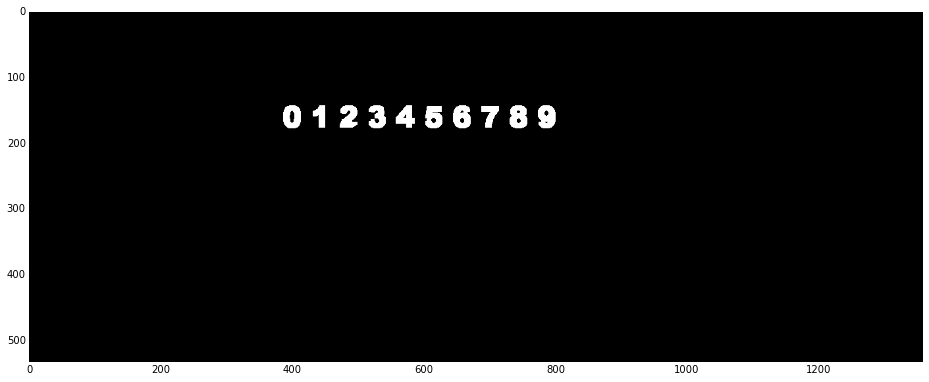

In [2]:
image_train=load_image('SOFT_priprema_train.jpg')
display_image(image_train)
image_train_bin=image_bin(image_gray(image_train))
display_image(image_train_bin)
image_train_bin=remove_noise(image_train_bin)
display_image(image_train_bin)


In [3]:
def select_roi(image_orig, image_bin):
    img, contours_borders, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    contours = []
    for contour in contours_borders:
        center, size, angle = cv2.minAreaRect(contour)
        xt,yt,w,h = cv2.boundingRect(contour)
            
        cv2.rectangle(image_orig,(xt,yt),(xt+w,yt+h),(255,0,0),2)
        region_points = []
        for i in range (xt,xt+w):
            for j in range(yt,yt+h):
                dist = cv2.pointPolygonTest(contour,(i,j),False)
                if dist>=0 and image_bin[j,i]==255: # da li se tacka nalazi unutar konture?
                    region_points.append([i,j])
        region = np.ndarray((len(region_points), 2), dtype=np.int16)
        for i, point in enumerate(region_points):
            x = point[0]
            y = point[1]
            region[i] = [x,y]
        contours.append(region)
    
    regions_dict = {}
    for contour in contours:
    
        min_x = min(contour[:,0])
        max_x = max(contour[:,0])
        min_y = min(contour[:,1])
        max_y = max(contour[:,1])
        
        region = np.zeros((max_y-min_y+1,max_x-min_x+1), dtype=np.int16)
        for point in contour:
            x = point[0]
            y = point[1]
            
            region[y-min_y,x-min_x] = 255

        
        regions_dict[min_x] = [resize_region(region), (min_x,min_y,max_x-min_x,max_y-min_y)]
        
    sorted_regions_dict = collections.OrderedDict(sorted(regions_dict.items()))
    sorted_regions = np.array(sorted_regions_dict.values())
    
    return image_orig, sorted_regions[:, 0]